In [1]:
import gym
import os 
import sys
import itertools
import numpy as np
import tensorflow as tf
from collections import defaultdict, namedtuple

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make('CartPole-v0')
env = env.unwrapped
env.seed(1)

print("env.action_sapce:", env.action_space.n)
print("env.observation_sapce:", env.observation_space.shape[0])
print("env.observation_space.high:", env.observation_space.high)
print("env.observation_space.low:", env.observation_space.low)

env.action_sapce: 2
env.observation_sapce: 4
env.observation_space.high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
env.observation_space.low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [3]:
class PolicyGradient():
    """
    Policy Gradient REinforcement Learning.
    used a 3 layer neural network as the policy network.
    """
    def __init__(self, n_x, n_y,
                learning_rate=0.01, load_path=None, save_path=None):
        self.n_x = n_x
        self.n_y = n_y
        self.lr = learning_rate
        self.episode_rewards = []
        
        self.__build_network()
        self.sess = tf.Session()
        
        tf.summary.FileWriter("logs_actor/", self.sess.graph)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        
    def __build_network(self):
        """
        build the natural network
        """
        # Create placeholders
        with tf.name_scope('actor_inputs'):
            self.X = tf.placeholder(tf.float32, shape=(self.n_x, None), name="state")
            self.Y = tf.placeholder(tf.float32, shape=(self.n_y, None), name="action")
            self.td_error = tf.placeholder(tf.float32, name="td_error")

        layer1_units = 10
        layer2_units = 10
        layer_output_units = self.n_y
        
        with tf.name_scope("actor_parameter"):
            W1 = self.__weigfht_variable([layer1_units, self.n_x], "aW1")
            b1 = self.__bias_bariable([layer1_units, 1], "ab1")
            W2 = self.__weigfht_variable([layer2_units, layer1_units], "aW2")
            b2 = self.__bias_bariable([layer2_units, 1], "ab2")
            W3 = self.__weigfht_variable([layer_output_units, layer2_units], "aW3")
            b3 = self.__bias_bariable([layer_output_units, 1], "ab3")
        
        with tf.name_scope("actor_layer1"):
            z1 = tf.add(tf.matmul(W1, self.X), b1)
            a1 = tf.nn.relu(z1)
        with tf.name_scope("actor_layer2"):
            z2 = tf.add(tf.matmul(W2, a1), b2)
            a2 = tf.nn.relu(z2)
        with tf.name_scope("actor_layer_output"):
            z3 = tf.add(tf.matmul(W3, a2), b3)
            a3 = tf.nn.softmax(z3)

        # Softmax outputs, we need to transpose as tensorflow nn functions expects them in this shape
        logits = tf.transpose(z3)
        labels = tf.transpose(self.Y)
        self.outputs_softmax = tf.nn.softmax(logits, name='A3')

        with tf.name_scope('actor_loss'):
            neg_log_prob = tf.squared_difference(logits, labels)
            loss = tf.reduce_mean(neg_log_prob * self.td_error)

        with tf.name_scope('actor_train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)
        
    def __weigfht_variable(self, shape, name):
        initial = tf.contrib.layers.xavier_initializer(seed=1)
        return tf.get_variable(name, shape, initializer=initial)
    
    def __bias_bariable(self, shape, name):
        initial = tf.contrib.layers.xavier_initializer(seed=1)
        return tf.get_variable(name, shape, initializer=initial)
        
    def __disc_and_norm_rewards(self):   
        disc_norm_ep_rewards = np.zeros_like(self.episode_rewards)
        disc_norm_ep_rewards -= np.mean(disc_norm_ep_rewards)
        disc_norm_ep_rewards /= np.std(disc_norm_ep_rewards)
        return disc_norm_ep_rewards
    
    def store_transition(self, error):
        """
        Store memory for network training
        """
        self.episode_rewards.append(error)
    
    def predict(self, state):
        """
        choose action base on given state
        """
        # reshape state to (num_features, 1)
        state = state[:, np.newaxis]
        
        # get softmax probabilities
        prob_weights = self.sess.run(self.outputs_softmax, feed_dict={self.X: state})
        
        # return sampled action
        action = np.random.choice(range(len(prob_weights.ravel())), p=prob_weights.ravel())
        return action
        
    def learn(self, state, action, reward):
        """
        Accroding the game memory traing the network
        """
        # discount and normalize episode reward
        disc_norm_ep_reward = self.__disc_and_norm_rewards()
        
        action__ = np.zeros(self.n_y)
        action__[action] = 1
        
        # train on episodes
        self.sess.run(self.train_op, feed_dict={
            self.X: np.vstack(state),
            self.Y: np.vstack(action__),
            self.td_error: disc_norm_ep_reward,  
        })
       
        
        # Reset the episode data
        self.episode_rewards  = []
        
        return disc_norm_ep_reward

In [4]:
class ValueEstimator():
    """
    Policy Gradient REinforcement Learning.
    used a 3 layer neural network as the policy network.
    """
    def __init__(self, n_x, n_y,
                learning_rate=0.01, load_path=None, save_path=None):
        self.n_x = n_x
        self.n_y = n_y
        self.lr = learning_rate
        self.episode_rewards = []
        
        self.__build_network()
        self.sess = tf.Session()
        
        tf.summary.FileWriter("critic_logs/", self.sess.graph)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        
    def __build_network(self):
        """
        build the natural network
        """
        # Create placeholders
        with tf.name_scope('critic_inputs'):
            self.X = tf.placeholder(tf.float32, shape=(self.n_x, None), name="X")
            self.Y = tf.placeholder(tf.float32, name="Y")

        layer1_units = 10
        layer2_units = 10
        layer_output_units = self.n_y
        
        with tf.name_scope("critic_parameter"):
            W1 = self.__weigfht_variable([layer1_units, self.n_x], "cW1")
            b1 = self.__bias_bariable([layer1_units, 1], "cb1")
            W2 = self.__weigfht_variable([layer2_units, layer1_units], "cW2")
            b2 = self.__bias_bariable([layer2_units, 1], "cb2")
            W3 = self.__weigfht_variable([layer_output_units, layer2_units], "cW3")
            b3 = self.__bias_bariable([layer_output_units, 1], "cb3")
        
        with tf.name_scope("critic_layer1"):
            z1 = tf.add(tf.matmul(W1, self.X), b1)
            a1 = tf.nn.relu(z1)
        with tf.name_scope("critic_layer2"):
            z2 = tf.add(tf.matmul(W2, a1), b2)
            a2 = tf.nn.relu(z2)
        with tf.name_scope("critic_layer_output"):
            z3 = tf.add(tf.matmul(W3, a2), b3)
            a3 = tf.nn.relu(z3)

        # transpose as tensorflow nn functions expects them in this shape
        logits = tf.transpose(z3)
        labels = tf.transpose(self.Y)
        self.outputs = tf.nn.relu(logits, name='A3')

        with tf.name_scope('critic_loss'):
            loss = tf.squared_difference(logits, labels)

        with tf.name_scope('critic_train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)
        
    def __weigfht_variable(self, shape, name):
        initial = tf.contrib.layers.xavier_initializer(seed=1)
        return tf.get_variable(name, shape, initializer=initial)
    
    def __bias_bariable(self, shape, name):
        initial = tf.contrib.layers.xavier_initializer(seed=1)
        return tf.get_variable(name, shape, initializer=initial)
        
    def __disc_and_norm_rewards(self):   
        disc_norm_ep_rewards = np.zeros_like(self.episode_rewards)
        disc_norm_ep_rewards -= np.mean(disc_norm_ep_rewards)
        disc_norm_ep_rewards /= np.std(disc_norm_ep_rewards)
        return disc_norm_ep_rewards
    
    def store_transition(self, target):
        """
        Store memory for network training
        """
        self.episode_rewards.append(target)
    
    def predict(self, state):
        """
        choose action base on given state
        """
        # reshape state to (num_features, 1)
        state = state[:, np.newaxis]
        
        # get softmax probabilities
        prob_weights = self.sess.run(self.outputs, feed_dict={self.X: state})
        
        return prob_weights[0]
        
    def learn(self, state, target):
        """
        Accroding the game memory traing the network
        """
        # discount and normalize episode reward
        disc_norm_ep_reward = self.__disc_and_norm_rewards()
        state = state[:, np.newaxis]
        
        # train on episodes
        self.sess.run(self.train_op, feed_dict={
            self.X: np.vstack(state),
            self.Y: np.vstack(target)})
        
        # Reset the episode data
        self.episode_rewards  = []

In [7]:
class Actor_Critic():
    """
    Actor Critic Algorithm. Optimizes the policy function approximator using policy gradient.
    """
    def __init__(self, env, num_episodes=200, learning_rate=0.01, reward_decay=0.95):
        
        self.nA = env.action_space.n
        self.nS = env.observation_space.shape[0]
        self.nR = 1
        self.env = env
        self.num_episodes = num_episodes
        self.reward_decay = reward_decay
        self.learning_rate = learning_rate
        self.rewards = []
        self.RENDER_REWARD_MIN = 50
        self.RENDER_ENV = False
        
        self.actor = PolicyGradient(n_x=self.nS, n_y=self.nA, 
                                 learning_rate=self.learning_rate)
        self.critic = ValueEstimator(n_x=self.nS, n_y=self.nR,
                                 learning_rate=self.learning_rate)
        
        # keep track of useful statistic
        record_head = namedtuple("Stats", ["episode_lengths","episode_rewards"])
        self.record = record_head(
                                episode_lengths = np.zeros(num_episodes),
                                episode_rewards = np.zeros(num_episodes))
        
    def mcpg_learn(self):
        """
        Actor Critic Algorithm core code. 
        """
        for i_episode in range(self.num_episodes):
            # print the number iter episode
            num_present = (i_episode+1) / self.num_episodes
            print("Episode {}/{}".format(i_episode + 1, self.num_episodes)) # end=""
            print("=" * round(num_present*60))
        
            # Reset the environment and pick the first action
            state = env.reset()
            reward_ = 0
            
            # One step in the environemt, replace code(while(True))
            for t in itertools.count():
#                 if self.RENDER_ENV: env.render()
                
                # step1: choose an action based on policy estimator(Actor)
                action = self.actor.predict(state)
                
                # step2: take a step in the environment
                next_state, reward, done, _ = env.step(action)
                print("state:", next_state,"reward:", reward, "action:",action)
                reward_ += reward
                
                # step3: calculate TD Target
                value_next = self.critic.predict(next_state)
                td_target = reward + self.reward_decay * value_next
                td_error = td_target - self.critic.predict(state)
                print("value_next", value_next, "td_target",td_target, "td_error", td_error)
                
                self.actor.store_transition(td_error)
                self.critic.store_transition(td_target)
                    
                # step4: update the value estimator(Critic)
                self.critic.learn(state, td_target)
                
                # step5: update the policy estimator(Actor)
                self.actor.learn(state, action, td_error)
                                
                # update statistics
                self.record.episode_rewards[i_episode] += reward
                self.record.episode_lengths[i_episode] = t
                
                if done:
                    self.rewards.append(reward_)
                    max_reward = np.amax(self.rewards)
                    
                    print("reward:{}, max reward:{}, episode len:{}\n".format(reward_, max_reward, t+1))
                    if max_reward > self.RENDER_REWARD_MIN: self.RENDER_ENV = True
                    break
                    
                # step6: save new state
                state = next_state
        
        return self.record

In [8]:
tf.reset_default_graph()
mcpg = Actor_Critic(env, num_episodes=200)
result = mcpg.mcpg_learn()

Episode 1/200

state: [ 0.02635582  0.15089482 -0.04301703 -0.30443059] reward: 1.0 action: 1
value_next [0.00820684] td_target [1.0077965] td_error [1.0077965]


E:\anaconda\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
E:\anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide


ValueError: probabilities contain NaN

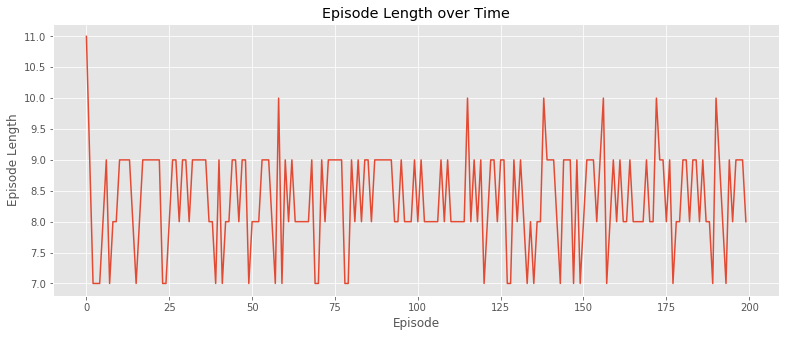

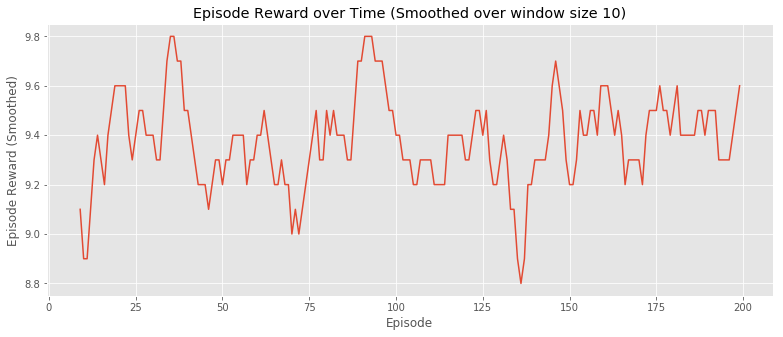

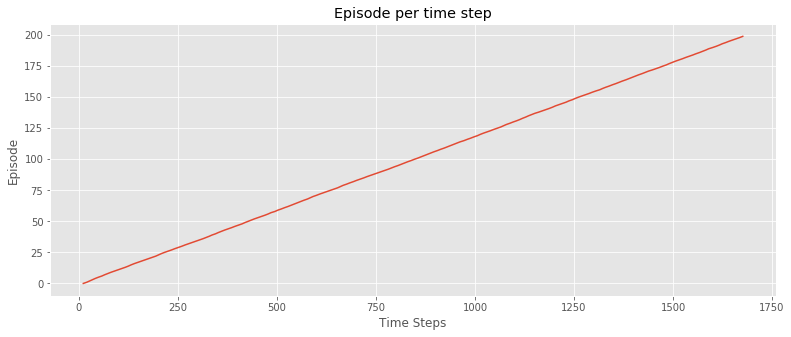

(<Figure size 936x360 with 1 Axes>,
 <Figure size 936x360 with 1 Axes>,
 <Figure size 936x360 with 1 Axes>)

In [9]:
import pandas as pd

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(13,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(13,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(13,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

plot_episode_stats(result)